In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

img1 = cv2.imread("assets/british-shorthair-9717301_640.jpg", cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread("assets/book-4468073_640.jpg", cv2.IMREAD_GRAYSCALE)


In [2]:
#Escala

def escala(imagem, sx, sy):
    nova_altura = int(imagem.shape[0] * sy)
    nova_largura = int(imagem.shape[1] * sx)
    nova_imagem = np.zeros((nova_altura, nova_largura), dtype=imagem.dtype)

    matriz_escala = np.array([
        [sx, 0, 0],
        [0, sy, 0],
        [0,  0, 1]
    ])

    for y in range(imagem.shape[0]):
        for x in range(imagem.shape[1]):
            ponto_original = np.array([x, y, 1])
            novo_ponto = matriz_escala @ ponto_original
            novo_x = int(novo_ponto[0])
            novo_y = int(novo_ponto[1])
            if 0 <= novo_y < nova_altura and 0 <= novo_x < nova_largura:
                nova_imagem[novo_y, novo_x] = imagem[y, x]

    return nova_imagem


In [3]:
#Interpolação

def escala_interpolacao_vizinhoMaisProximo(imagem, sx, sy):
    altura, largura = imagem.shape
    nova_altura = int(altura * sy)
    nova_largura = int(largura * sx)
    nova_imagem = np.zeros((nova_altura, nova_largura), dtype=imagem.dtype)

    matriz_escala = np.array([
        [sx, 0, 0],
        [0, sy, 0],
        [0,  0, 1]
    ])

    matriz_inversa = np.linalg.inv(matriz_escala)

    for y in range(nova_altura):
        for x in range(nova_largura):
            ponto = np.array([x, y, 1])
            ponto_original = matriz_inversa @ ponto
            orig_x = int(round(ponto_original[0]))
            orig_y = int(round(ponto_original[1]))
            if 0 <= orig_x < largura and 0 <= orig_y < altura:
                nova_imagem[y, x] = imagem[orig_y, orig_x]

    return nova_imagem

In [4]:
#Interpolação Bicúbica
def cubic(p, x):
    """Função de interpolação cúbica para 4 pontos p e posição x (0 <= x <= 1)"""
    return (
        p[1] + 0.5 * x * (p[2] - p[0] +
        x * (2*p[0] - 5*p[1] + 4*p[2] - p[3] +
        x * (3*(p[1] - p[2]) + p[3] - p[0])))
    )

def get_pixel(imagem, x, y):
    """Evita acessar fora da imagem"""
    altura, largura = imagem.shape
    x = min(max(x, 0), largura - 1)
    y = min(max(y, 0), altura - 1)
    return float(imagem[y, x])

def escala_interpolacao_bicubica(imagem, sx, sy):
    altura, largura = imagem.shape
    nova_altura = int(altura * sy)
    nova_largura = int(largura * sx)
    nova_imagem = np.zeros((nova_altura, nova_largura), dtype=np.uint8)

    matriz_escala = np.array([
        [sx, 0, 0],
        [0, sy, 0],
        [0,  0, 1]
    ])
    matriz_inversa = np.linalg.inv(matriz_escala)

    for y in range(nova_altura):
        for x in range(nova_largura):
            ponto = np.array([x, y, 1])
            ponto_original = matriz_inversa @ ponto
            orig_x, orig_y = ponto_original[0], ponto_original[1]

            x_base = int(np.floor(orig_x))
            y_base = int(np.floor(orig_y))
            dx = orig_x - x_base
            dy = orig_y - y_base

            # Coletar os 4x4 pixels
            valores = []
            for m in range(-1, 3):  # 4 linhas
                linha = []
                for n in range(-1, 3):  # 4 colunas
                    linha.append(get_pixel(imagem, x_base + n, y_base + m))
                valores.append(linha)

            # Interpola nas colunas (horizontal)
            colunas_interpoladas = [cubic(valores[i], dx) for i in range(4)]

            # Interpola nas linhas (vertical)
            valor_final = cubic(colunas_interpoladas, dy)

            # Clampa o valor para 0-255
            nova_imagem[y, x] = np.clip(valor_final, 0, 255)

    return nova_imagem


In [5]:
sx, sy = 2, 2

#Aplicando funções nas imagens
img_escala = escala(img1, sx, sy)
img_vizinho = escala_interpolacao_vizinhoMaisProximo(img1, sx, sy)
img_bicubica = escala_interpolacao_bicubica(img1, sx, sy)

img2_escala = escala(img2, sx, sy)
img2_vizinho = escala_interpolacao_vizinhoMaisProximo(img2, sx, sy)
img2_bicubica = escala_interpolacao_bicubica(img2, sx, sy)

#Recorte para Zoom
tamanho = 150
altura, largura = img1.shape

#Coordenadas
x0 = (largura - tamanho) // 2
y0 = (altura - tamanho) // 2
recorte_x = tamanho
recorte_y = tamanho

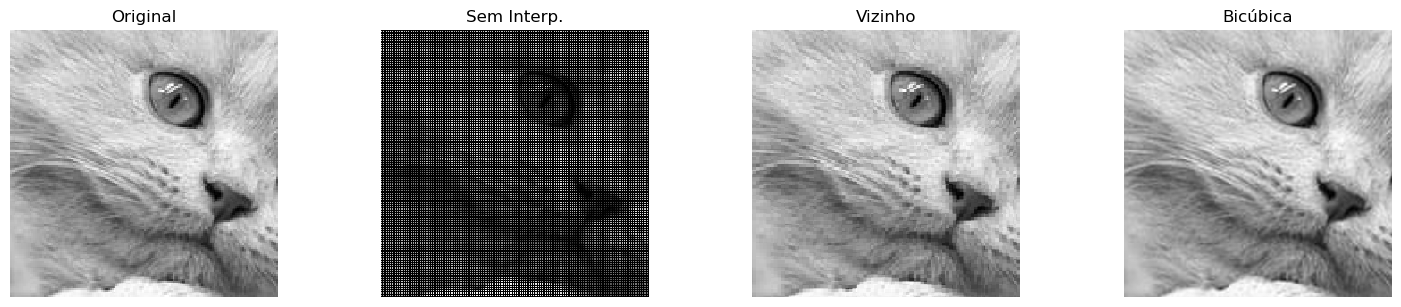

In [6]:
plt.figure(figsize=(15, 6))

#Recortes
plt.subplot(2, 4, 5)
plt.imshow(img1[y0:y0+recorte_y, x0:x0+recorte_x], cmap='gray', interpolation='none')
plt.title("Original")
plt.axis('off')

plt.subplot(2, 4, 6)
plt.imshow(img_escala[y0*sy:(y0+recorte_y)*sy, x0*sx:(x0+recorte_x)*sx], cmap='gray', interpolation='none')
plt.title("Sem Interp.")
plt.axis('off')

plt.subplot(2, 4, 7)
plt.imshow(img_vizinho[y0*sy:(y0+recorte_y)*sy, x0*sx:(x0+recorte_x)*sx], cmap='gray', interpolation='none')
plt.title("Vizinho")
plt.axis('off')

plt.subplot(2, 4, 8)
plt.imshow(img_bicubica[y0*sy:(y0+recorte_y)*sy, x0*sx:(x0+recorte_x)*sx], cmap='gray', interpolation='none')
plt.title("Bicúbica")
plt.axis('off')

plt.tight_layout()
plt.show()

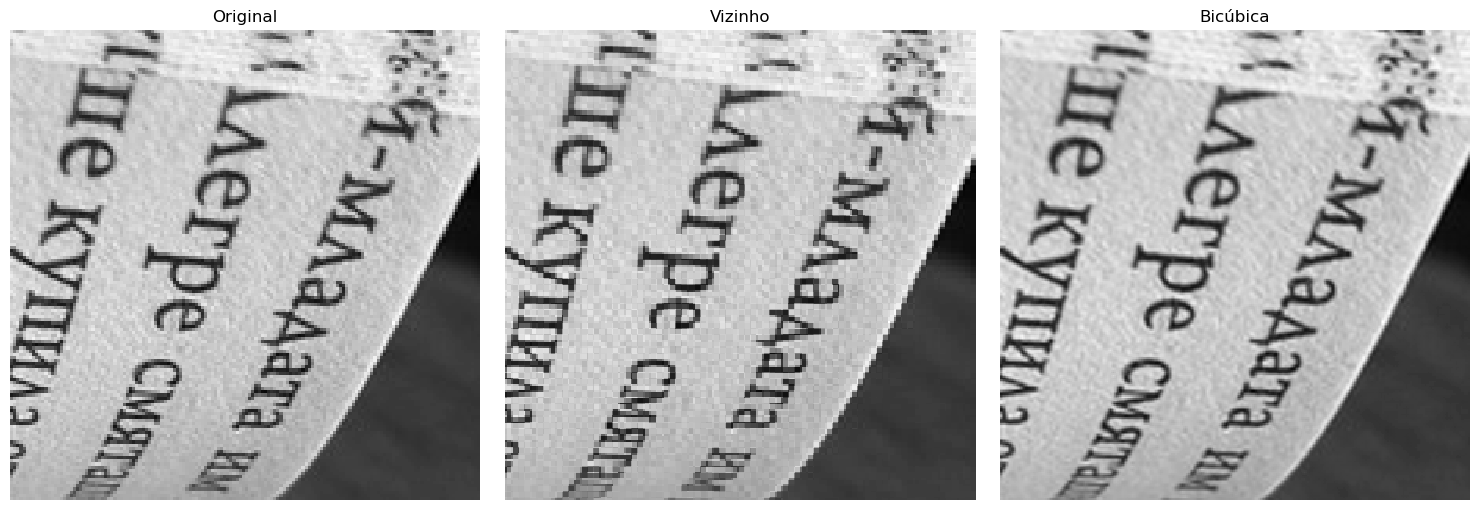

In [7]:
plt.figure(figsize=(15, 5))

# Recorte da imagem original
plt.subplot(1, 3, 1)
plt.imshow(img2[y0:y0+recorte_y, x0:x0+recorte_x], cmap='gray', interpolation='none')
plt.title("Original")
plt.axis('off')

# Recorte do vizinho mais próximo
plt.subplot(1, 3, 2)
plt.imshow(img2_vizinho[y0*sy:(y0+recorte_y)*sy, x0*sx:(x0+recorte_x)*sx], cmap='gray', interpolation='none')
plt.title("Vizinho")
plt.axis('off')

# Recorte da interpolação bicúbica
plt.subplot(1, 3, 3)
plt.imshow(img2_bicubica[y0*sy:(y0+recorte_y)*sy, x0*sx:(x0+recorte_x)*sx], cmap='gray', interpolation='none')
plt.title("Bicúbica")
plt.axis('off')

plt.tight_layout()
plt.show()


In [8]:
def mtz_rotacao(theta):
  return np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta),  np.cos(theta), 0],
        [0,              0,             1]
    ])

def mtz_translacao(xr,yr):
  return np.array([
        [1, 0, xr],
        [0,  1, yr],
        [0, 0, 1]
    ])

def rotacao(imagem, angulo):
    # Converte para radianos
    theta = np.deg2rad(angulo)

    # Altura e largura original
    h, w = imagem.shape

    # Centro da imagem
    cx, cy = w // 2, h // 2

    # Matriz de rotação (em torno da origem)
    matriz_rotacao = mtz_rotacao(theta)

    # Matriz de translação
    matriz_tranlacao_para_origem = mtz_translacao(-cx,-cy)
    matriz_tranlacao_volta = mtz_translacao(cx,cy)

    # Nova imagem (com mesmo tamanho)
    nova_imagem = np.zeros_like(imagem)

    for y in range(h):
        for x in range(w):

            ponto_rotacionado = np.array([x, y, 1])
            ponto_resultado = matriz_tranlacao_volta @ matriz_rotacao @ matriz_tranlacao_para_origem @ ponto_rotacionado

            # Verifica se está dentro dos limites da imagem original
            if 0 <= ponto_resultado[0]  < w and 0 <= ponto_resultado[1] < h:
              nova_imagem[int(ponto_resultado[1]), int(ponto_resultado[0])] = imagem[y, x]

    return nova_imagem



In [9]:
def rotacao_interpolacao_vizinhoMaisProximo(imagem, angulo):
    # Converte para radianos
    theta = np.deg2rad(angulo)

    # Altura e largura original
    h, w = imagem.shape

    # Centro da imagem
    cx, cy = w // 2, h // 2

    # Matriz de rotação (em torno da origem)
    matriz_rotacao = mtz_rotacao(theta)

    # Matriz de translação
    matriz_tranlacao_para_origem = mtz_translacao(-cx,-cy)
    matriz_tranlacao_volta = mtz_translacao(cx,cy)

    # Nova imagem (com mesmo tamanho)
    nova_imagem = np.zeros_like(imagem)

    for y in range(h):
        for x in range(w):

            ponto_rotacionado = np.array([x, y, 1])
            ponto_resultado = matriz_tranlacao_volta @ np.linalg.inv(matriz_rotacao) @ matriz_tranlacao_para_origem @ ponto_rotacionado

            # Verifica se está dentro dos limites da imagem original
            if 0 <= ponto_resultado[0]  < w and 0 <= ponto_resultado[1] < h:
              nova_imagem[y, x] = imagem[int(ponto_resultado[1]), int(ponto_resultado[0])]

    return nova_imagem


In [10]:
def B(s):
  if 0 <= abs(s) < 1:
    return ((1.5)*abs(s)**3)-(2.5*abs(s)**2)+1
  if 1<=abs(s)<2:
    return (-0.5*abs(s)**3)+(2.5*abs(s)**2)-4*abs(s)+2
  return 0

def interpolacao_bicubica(imagem, x, y):
    """
    Retorna o valor interpolado no ponto (x, y)
    da imagem (como array NumPy).
    """

    altura, largura = imagem.shape
    x0 = int(np.floor(x))
    y0 = int(np.floor(y))

    resultado = 0.0

    for m in range(-1, 3):  # i: -1 a 2
        for n in range(-1, 3):  # j: -1 a 2
            xi = x0 + m
            yj = y0 + n

            # Evita sair dos limites da imagem
            if xi < 0: xi = 0
            if xi >= largura: xi = largura - 1
            if yj < 0: yj = 0
            if yj >= altura: yj = altura - 1

            pixel = imagem[yj, xi]
            peso = B(m - (x - x0)) * B(n - (y - y0))
            resultado += pixel * peso

    # Garante que o resultado esteja no intervalo de intensidade [0, 255]
    return np.clip(resultado, 0, 255)


def rotacao_interpolacao_bicubica(imagem, angulo):
    theta = np.deg2rad(angulo)
    h, w = imagem.shape
    cx, cy = w // 2, h // 2

    # Matrizes
    matriz_rotacao = mtz_rotacao(theta)
    matriz_tranlacao_para_origem = mtz_translacao(-cx, -cy)
    matriz_tranlacao_volta = mtz_translacao(cx, cy)

    # Matriz composta
    transformacao_direta = matriz_tranlacao_volta @ matriz_rotacao @ matriz_tranlacao_para_origem

    # MATRIZ INVERSA
    transformacao_inversa = np.linalg.inv(transformacao_direta)

    nova_imagem = np.zeros_like(imagem)

    for y_novo in range(h):
        for x_novo in range(w):
            # Ponto no sistema da imagem destino
            ponto_novo = np.array([x_novo, y_novo, 1])

            # Aplicar transformação
            x_original, y_original, _ = transformacao_inversa @ ponto_novo

            if 0 <= x_original < w and 0 <= y_original < h:
                nova_imagem[y_novo, x_novo] = interpolacao_bicubica(imagem, x_original, y_original)

    return nova_imagem



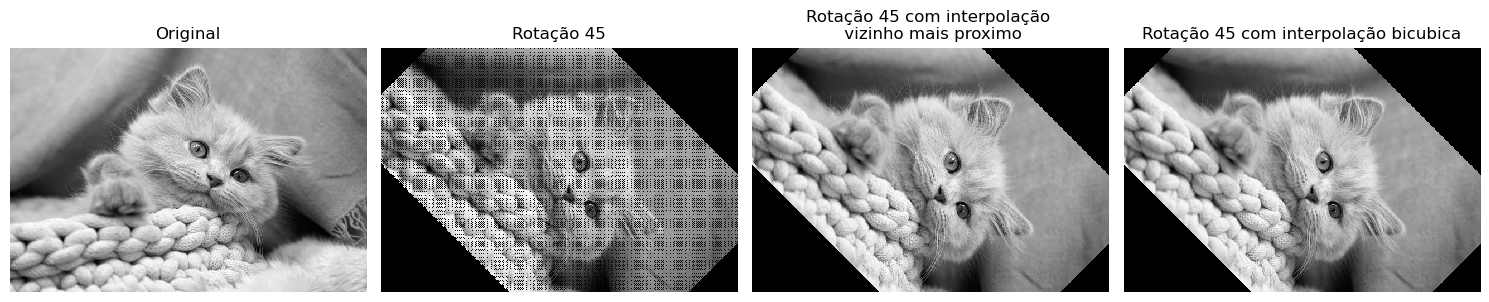

In [11]:

img_rotacao = rotacao(img1,45)
img_rotacao_interpolacao_vizinhoMaisProximo = rotacao_interpolacao_vizinhoMaisProximo(img1,45)
img_rotacao_interpolacao_bicubica = rotacao_interpolacao_bicubica(img1,45)

plt.figure(figsize=(15, 6))
#Original
plt.subplot(1, 4, 1)
plt.imshow(img1, cmap='gray', interpolation='none')
plt.title("Original")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(img_rotacao, cmap='gray', interpolation='none')
plt.title("Rotação 45")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(img_rotacao_interpolacao_vizinhoMaisProximo, cmap='gray', interpolation='none')
plt.title("Rotação 45 com interpolação \n vizinho mais proximo")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(img_rotacao_interpolacao_bicubica , cmap='gray', interpolation='none')
plt.title("Rotação 45 com interpolação bicubica")
plt.axis('off')

plt.tight_layout()
plt.show()

In [12]:
def mtz_cisalhamento_x(shx):
    return np.array([
        [1, shx, 0],
        [0, 1,   0],
        [0, 0,   1]
    ])

def mtz_cisalhamento_y(shy):
    return np.array([
        [1,   0, 0],
        [shy, 1, 0],
        [0,   0, 1]
    ])


def cisalhamento_sem_interpolacao(imagem, shx=0.0, shy=0.0):
    h, w = imagem.shape
    cx, cy = w // 2, h // 2

    matriz_cisalhamento = (
        mtz_cisalhamento_x(shx) @ mtz_cisalhamento_y(shy)
    )

    translacao_para_origem = mtz_translacao(-cx, -cy)
    translacao_de_volta = mtz_translacao(cx, cy)

    transformacao_direta = translacao_de_volta @ matriz_cisalhamento @ translacao_para_origem
    transformacao_inversa = np.linalg.inv(transformacao_direta)

    nova_imagem = np.zeros_like(imagem)

    for y_novo in range(h):
        for x_novo in range(w):
            ponto_novo = np.array([x_novo, y_novo, 1])
            x_origem, y_origem, _ = transformacao_inversa @ ponto_novo

            x_origem = int(round(x_origem))
            y_origem = int(round(y_origem))

            if 0 <= x_origem < w and 0 <= y_origem < h:
                nova_imagem[y_novo, x_novo] = imagem[y_origem, x_origem]

    return nova_imagem


def cisalhamento_interpolacao_bicubica(imagem, shx=0.0, shy=0.0):
    h, w = imagem.shape
    cx, cy = w // 2, h // 2

    # Define matriz de cisalhamento
    matriz_cisalhamento = (
        mtz_cisalhamento_x(shx) @ mtz_cisalhamento_y(shy)
    )

    # Translação
    translacao_para_origem = mtz_translacao(-cx, -cy)
    translacao_de_volta = mtz_translacao(cx, cy)

    # Transformação composta
    transformacao_direta = translacao_de_volta @ matriz_cisalhamento @ translacao_para_origem

    # Inversa
    transformacao_inversa = np.linalg.inv(transformacao_direta)

    nova_imagem = np.zeros_like(imagem)

    for y_novo in range(h):
        for x_novo in range(w):
            ponto_novo = np.array([x_novo, y_novo, 1])
            x_original, y_original, _ = transformacao_inversa @ ponto_novo

            if 0 <= x_original < w and 0 <= y_original < h:
                nova_imagem[y_novo, x_novo] = interpolacao_bicubica(imagem, x_original, y_original)

    return nova_imagem




(-0.5, 639.5, 438.5, -0.5)

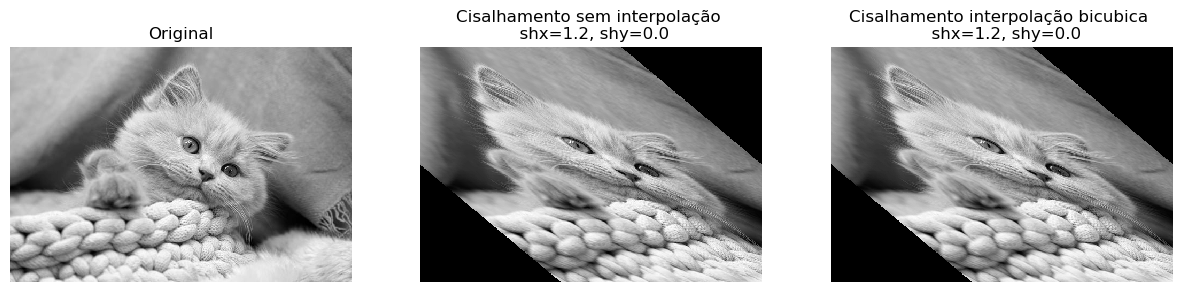

In [13]:

img_cisalhamento_sem_interpolacao = cisalhamento_sem_interpolacao(img1,1.2,0)
img_cisalhamento_interpolacao_bicubica = cisalhamento_interpolacao_bicubica(img1,1.2,0)

plt.figure(figsize=(15, 6))
#Original
plt.subplot(1, 3, 1)
plt.imshow(img1, cmap='gray', interpolation='none')
plt.title("Original")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img_cisalhamento_sem_interpolacao, cmap='gray', interpolation='none')
plt.title("Cisalhamento sem interpolação \n  shx=1.2, shy=0.0 ")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img_cisalhamento_interpolacao_bicubica, cmap='gray', interpolation='none')
plt.title("Cisalhamento interpolação bicubica \n  shx=1.2, shy=0.0")
plt.axis('off')